h: 0.10000002384185791
[                                                  ]                                                   ] 0%h: 0.3499999940395355
[                                                  ]                                                   ] 0%h: 0.6000000238418579
[                                                  ]                                                   ] 0%h: 0.8500001430511475
[                                                  ]                                                   ] 0%h values: [0.100000024, 0.35, 0.6, 0.85000014]
Average slope base: 1.051
Average slope saar model: 0.391


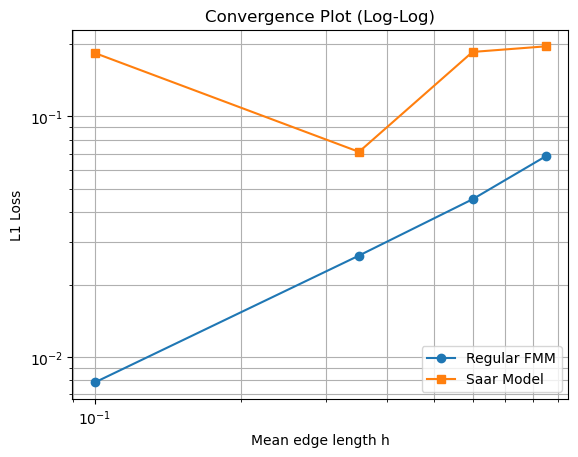

l1_errors_base: [0.007852408231165819, 0.026409253383496437, 0.04527291947797094, 0.06838151202250133]
l1_errors_saar_model: [0.1833873967185404, 0.07126422224110589, 0.18539802368241898, 0.19564447077405628]


In [ ]:
import torch
import heapq
import pyvista as pv
import numpy as np
from collections import deque
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.sparse import csr_matrix
from models.sphere_models import SpherePointNetRing, SpherePointNetRingFeatureExtractionFirstRing, SpherePointNetRingAttention, SpherePointNetRingAttentionAndConvolution
from models.surface_models import surface_skips
from make_surface_dataset import fmm

global_local_solver = None
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def make_sphere(radius=1.0, nsub=4):
    # sphere = pv.Sphere(radius=radius, theta_resolution=theta_resolution//2, phi_resolution=phi_resolution)
    sphere = pv.Icosphere(radius=radius, nsub=nsub)  # More uniform

    points = sphere.points.astype(np.float32)
    faces = sphere.faces.reshape(-1, 4)[:, 1:]

    n_points = len(points)
    edge_set = set()
    rows, cols, dists = [], [], []
    edge_lengths = []

    for tri in faces:
        for i in range(3):
            a, b = tri[i], tri[(i + 1) % 3]
            edge = tuple(sorted((a, b)))
            if edge not in edge_set:
                edge_set.add(edge)
                dist = np.linalg.norm(points[a] - points[b])
                edge_lengths.append(dist)  
                rows.extend([a, b])
                cols.extend([b, a])
                dists.extend([dist, dist])

    graph = csr_matrix((dists, (rows, cols)), shape=(n_points, n_points))
    h = np.mean(edge_lengths)

    return graph, faces, points, sphere, h

def plot_errors(h_values, errors_regular_FMM, errors_saar_model):
    plt.figure()
    plt.loglog(h_values, errors_regular_FMM, marker='o', label='Regular FMM')
    plt.loglog(h_values, errors_saar_model, marker='s', label='Saar Model')
    plt.xlabel('Mean edge length h')
    plt.ylabel('L1 Loss')
    plt.title('Convergence Plot (Log-Log)')
    plt.grid(True, which='both')
    plt.legend()
    plt.show()


def get_3_ring_visited_neighbors(p, graph, status, u, points):
    visited = []
    queue = deque([(p, 0)])  # (node, depth)
    seen = set([p])
    
    while queue:
        current, depth = queue.popleft()
        if depth > 3:
            continue
        if status[current] == 'Visited' and current != p:
            point_xyz = tuple(points[current])  # (x, y, z)
            visited.append([point_xyz[0], point_xyz[1], point_xyz[2], u[current]])
        for neighbor in graph[current].nonzero()[1]:
            if neighbor not in seen:
                seen.add(neighbor)
                queue.append((neighbor, depth + 1))

    return torch.tensor(visited, dtype=torch.float32).T  # Shape: [4, N]


def local_solver_dijkstra(p, graph, status, u, points):
    min_val = np.inf
    for neighbor in graph[p].nonzero()[1]:
        if status[neighbor] == 'Visited':
            candidate = u[neighbor] + graph[p, neighbor]
            if candidate < min_val:
                min_val = candidate
    return min_val


def local_solver_ron(p, graph, status, u, points):
    neighbors = graph[p].nonzero()[1]
    visited_neighbors = [n for n in neighbors if status[n] == 'Visited']

    if not visited_neighbors:
        return u[p] 

    min_u = min(u[n] + np.linalg.norm(points[p] - points[n]) for n in visited_neighbors)

    best_u = min_u
    for i in range(len(visited_neighbors)):
        for j in range(i + 1, len(visited_neighbors)):
            a, b = visited_neighbors[i], visited_neighbors[j]
            ua, ub = u[a], u[b]
            pa, pb, pp = points[a], points[b], points[p]
            dab = np.linalg.norm(pa - pb)

            # Upwind Eikonal solver
            if abs(ua - ub) >= dab:
                continue  # upwind condition not met, use min

            s = (ua + ub + np.sqrt(2 * dab**2 - (ua - ub)**2)) / 2
            if s < best_u:
                best_u = s

    return best_u


def local_solver_model_ring3(p, graph, status, u, points): #fast
    visited_neighbors = get_3_ring_visited_neighbors(p, graph, status, u, points).to(device)  # shape: (4, N) with N ≤ 90
    num_valid = visited_neighbors.shape[1]
    visited_neighbors_padded = F.pad(visited_neighbors, (0, 90 - num_valid), "constant", 0).unsqueeze(0)  # (1, 4, 90)
    mask = torch.zeros(90, dtype=torch.float32)
    mask[:num_valid] = 1
    mask = mask.unsqueeze(0)  # (1, 90)
    point_xyz = torch.tensor(points[p], dtype=torch.float32).unsqueeze(0)  # (1, 3)
    visited_neighbors_padded = visited_neighbors_padded.to(device)
    point_xyz = point_xyz.to(device)
    mask = mask.to(device)
    
    distance_estimation = global_local_solver(visited_neighbors_padded, point_xyz, mask).item()
    return distance_estimation


# def FMM_with_local_solver(graph: csr_matrix, points, source_points, local_solver): NOT REAL!
#     n_points = graph.shape[0]
#     u = np.full(n_points, np.inf)
#     status = np.full(n_points, 'Unvisited', dtype=object)
#     heap = []  # (u value, point index)

#     for p in source_points:
#         u[p] = 0
#         status[p] = 'Visited'
#         for neighbor in graph[p].nonzero()[1]:
#             if status[neighbor] == 'Unvisited':
#                 status[neighbor] = 'Wavefront'
#                 heapq.heappush(heap, (u[p] + graph[p, neighbor], neighbor))

#     while heap:
#         _, p = heapq.heappop(heap)
#         if status[p] == 'Visited':
#             continue 

#         u[p] = local_solver(p, graph, status, u, points)
#         status[p] = 'Visited'

#         for neighbor in graph[p].nonzero()[1]:
#             if status[neighbor] == 'Unvisited' or status[neighbor] == 'Wavefront': #Omer added
#                 if status[neighbor] == 'Unvisited':
#                     status[neighbor] = 'Wavefront'
#                     u[neighbor] = u[p] + graph[p, neighbor]
#                 else:
#                     new_distance = u[p] + graph[p, neighbor]
#                     if new_distance < u[neighbor]:
#                         u[neighbor] = new_distance
#                 heapq.heappush(heap, (u[p] + graph[p, neighbor], neighbor))
#     return u


def FMM_with_local_solver(graph: csr_matrix, points, source_points, local_solver):  #Implementation of the "real" FMM
    n_points = graph.shape[0]
    u = np.full(n_points, np.inf)
    status = np.full(n_points, 'Unvisited', dtype=object)
    heap = []  # (u value, point index)

    for p in source_points:
        u[p] = 0
        status[p] = 'Visited'
        for neighbor in graph[p].nonzero()[1]:
            if status[neighbor] == 'Unvisited':
                status[neighbor] = 'Wavefront'
                heapq.heappush(heap, (u[p] + graph[p, neighbor], neighbor))

    while heap:
        _, p = heapq.heappop(heap)
        if status[p] == 'Visited':
            continue

        u[p] = local_solver(p, graph, status, u, points)
        status[p] = 'Visited'

        for neighbor in graph[p].nonzero()[1]:
            if status[neighbor] == 'Unvisited' or status[neighbor] == 'Wavefront':
                status[neighbor] = 'Wavefront'
                u[neighbor] = local_solver(neighbor, graph, status, u, points)
                heapq.heappush(heap, (u[p] + graph[p, neighbor], neighbor))
            # elif status[neighbor] == 'Wavefront':
            #     new_distance = local_solver(neighbor, graph, status, u, points)
            #     if new_distance < u[neighbor]:
            #         u[neighbor] = new_distance
            #         heapq.heappush(heap, (u[p] + graph[p, neighbor], neighbor))
    return u

def make_spheres_radiuses_set(nsub=2, start_h=0.1, end_h=1.6, step=0.1):   #to calculate desired h and get r,nsub
    graph, faces, points, sphere, h = make_sphere(radius=1, nsub=nsub)
    radiuses = (np.arange(start_h, end_h, step) / h)  #here we change
    nsub_radises = [(r, nsub) for r in radiuses] 
    return nsub_radises

def true_distances(points, radius, source_idx):
    points = points.astype(np.float64)
    norm_points = points / np.linalg.norm(points, axis=1, keepdims=True)
    norm_source = norm_points[source_idx:source_idx+1]
    cosines = np.einsum('ij,ij->i', norm_points, norm_source)
    cosines = np.clip(cosines, -1.0, 1.0)
    dists = radius * np.arccos(cosines)
    dists[source_idx] = 0.0
    return dists


nsub_radius = make_spheres_radiuses_set(nsub=2, start_h=0.1, end_h=1.0, step=0.25)
# nsub_radius = [(1.0, 1), (1.0, 2), (1.0, 3), (1.0, 4)]
h_vals = []
l1_errors_base = []
l1_errors_saar_model = []#
np.random.seed(0)
for n_r in nsub_radius:
    radius = n_r[0]
    nsub = n_r[1]
    #points = coordinates of each point
    #graph = (number of node a, number of node b, edge length between a and b)
    graph, faces, points, sphere, h = make_sphere(radius=radius, nsub=nsub) #radius=10, nsub=r
    source_idxs = np.random.choice(len(points), size=1, replace=False) #randomly select points from the sphere
    print(f"h: {h}")

    #Load the local solver (the model)
    local_solver = SpherePointNetRing()
    local_solver = SpherePointNetRingFeatureExtractionFirstRing()
    local_solver = SpherePointNetRingAttention()
    local_solver = SpherePointNetRingAttentionAndConvolution()
    checkpoint = torch.load("checkpoints/high_res/attn_epoch0_loss2.9647249203179677e-05.pt", map_location=device)
    # local_solver = surface_skips()
    # checkpoint = torch.load("checkpoints/high_res/attn_epoch0_loss2.9647249203179677e-05.pt", map_location=device)
    local_solver.load_state_dict(checkpoint["model_state_dict"])
    local_solver = local_solver.to(device)
    local_solver.eval()
    global_local_solver = local_solver

    l1_losses_base = []
    l1_losses_saar_model = []
    l1_losses_fmm = []
    for source_idx in source_idxs:
        distances_base = fmm(V=points, F=faces, source_index=source_idx)
        distances_saar_model = FMM_with_local_solver(graph, points, [source_idx], local_solver_model_ring3)

        true_geodesic = true_distances(points, radius, source_idx)
        l1_losses_base.append(np.mean(np.abs(distances_base - true_geodesic)))
        l1_losses_saar_model.append(np.mean(np.abs(distances_saar_model - true_geodesic)))        
        # sphere["GeodesicDistance"] = true_geodesic
        # sphere.plot(scalars="GeodesicDistance", cmap="viridis", show_edges=False)
        # sphere["GeodesicDistance"] = distances_regular_FMM
        # sphere.plot(scalars="GeodesicDistance", cmap="viridis", show_edges=False)
        # sphere["GeodesicDistance"] = distances_saar_model
        # sphere.plot(scalars="GeodesicDistance", cmap="viridis", show_edges=False)

    l1_loss_regular_FMM = np.mean(l1_losses_base)
    l1_loss_saar_model = np.mean(l1_losses_saar_model)
    l1_errors_base.append(l1_loss_regular_FMM)
    l1_errors_saar_model.append(l1_loss_saar_model)
    h_vals.append(h)


average_slope_regular_FMM = np.mean(np.diff(np.log(l1_errors_base)) / np.diff(np.log(h_vals)))
average_slope_saar_model = np.mean(np.diff(np.log(l1_errors_saar_model)) / np.diff(np.log(h_vals)))
print(f"h values: {h_vals}")
print(f"Average slope base: {average_slope_regular_FMM:.3f}")
print(f"Average slope saar model: {average_slope_saar_model:.3f}")
plot_errors(h_vals, l1_errors_base, l1_errors_saar_model)
print(f"l1_errors_base: {l1_errors_base}")
print(f"l1_errors_saar_model: {l1_errors_saar_model}")